In [1]:
import os
import numpy as np
import sklearn
import PIL
from PIL.Image import fromarray
import tensorflow as tf
import pydicom
import dicom_numpy
import matplotlib.pyplot as plt
import time
import cv2

In [2]:
from pathlib import Path

dicomFiles = []
for filename in os.listdir("../IRB_Exempt_Exports/"):
    if filename == 'DICOM_CNN':
        continue
    path = Path.home()
    path = path / 'IRB_Exempt_Exports' / filename / 'DICOM'
    prev_path = Path.home()
    for subdir, dirs, files in os.walk(path):
        if (len(files) == 1):
            continue
        for file in files:
            dicomFiles.append(subdir + '/' + file)
print(len(dicomFiles))

72200


In [3]:
# Get ref file
RefDs = pydicom.read_file(dicomFiles[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(dicomFiles))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
train_images = []
for i, file in enumerate(dicomFiles):
    if i % 1000 == 0:
        print(i)
    ds = pydicom.read_file(file)
    try:
        a = ds.pixel_array
    except:
        continue
    ArrayDicom[:, :, i] = ds.pixel_array
    
    data = np.array(ds.pixel_array)
    train_images.append(data)
    if i == 1000:
        break
train_images = np.array(train_images)
test_images = train_images[-100:]

0
1000


In [4]:
train_X = train_images.reshape(train_images.shape[0], 512, 512, 1).astype('float32')
test_X = test_images.reshape(test_images.shape[0], 512, 512, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images = train_X / 255.
test_images = test_X / 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [5]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [7]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(512, 512, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=128*128*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(128, 128, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [9]:
epochs = 10
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

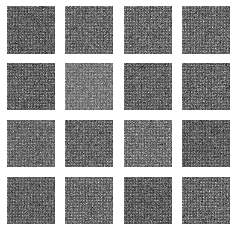

Epoch: 1, Test set ELBO: -181370.375, time elapse for current epoch 187.09956312179565


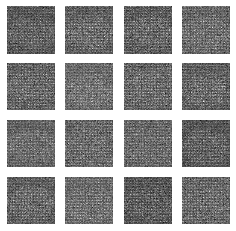

Epoch: 2, Test set ELBO: -174926.4375, time elapse for current epoch 181.48750162124634


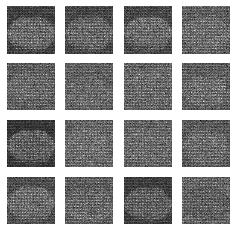

Epoch: 3, Test set ELBO: -159077.953125, time elapse for current epoch 178.0869960784912


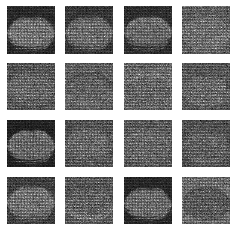

Epoch: 4, Test set ELBO: -145365.71875, time elapse for current epoch 177.89673852920532


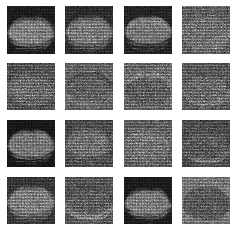

Epoch: 5, Test set ELBO: -135433.1875, time elapse for current epoch 179.0788857936859


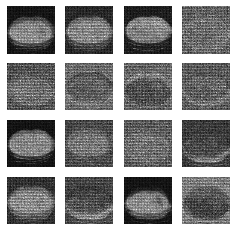

Epoch: 6, Test set ELBO: -129421.640625, time elapse for current epoch 182.34520411491394


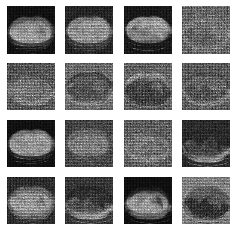

Epoch: 7, Test set ELBO: -126151.0390625, time elapse for current epoch 182.17565894126892


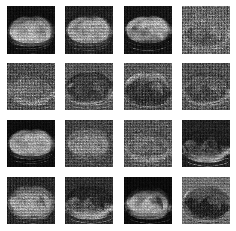

Epoch: 8, Test set ELBO: -124030.71875, time elapse for current epoch 181.2573938369751


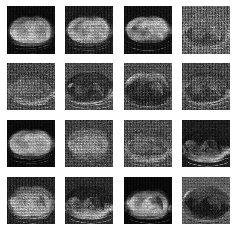

Epoch: 9, Test set ELBO: -121835.859375, time elapse for current epoch 179.9474184513092


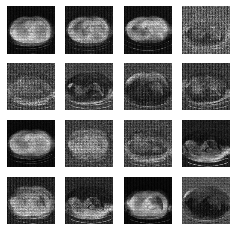

Epoch: 10, Test set ELBO: -118914.2578125, time elapse for current epoch 182.02119326591492


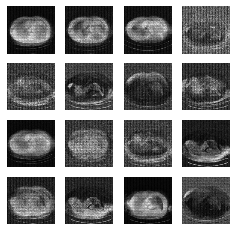

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

In [11]:
model.save_weights('model.h5')

In [56]:
model.load_weights('model.h5')

import cv2
import random

def visualizeInterpolation(i, start, end, encoder, decoder, save=False, nbSteps=5):
    print("Generating interpolations...")

    # Create micro batch
    X = np.array([start,end])

    # Compute latent space projection
    latentX = encoder(X)
    latentStart, latentEnd = latentX

    # Get original image for comparison
    startImage, endImage = X

    vectors = []
    normalImages = []
    #Linear interpolation
    alphaValues = np.linspace(0, 1, nbSteps)
    for alpha in alphaValues:
        # Latent space interpolation
        vector = latentStart*(1-alpha) + latentEnd*alpha
        vectors.append(vector)
        # Image space interpolation
        blendImage = cv2.addWeighted(startImage,1-alpha,endImage,alpha,0)
        normalImages.append(blendImage)

    # Decode latent space vectors
    vectors = np.reshape(np.array(vectors), (10, 50))
    reconstructions = decoder(vectors).numpy()
    #print(reconstructions.shape)
    #reconstructions = reconstructions.numpy().reshape((5,2,512,512))

    # Put final image together
    resultLatent = None
    resultImage = None
    
    if save:
        hashName = 'myimage' + str(i)
    
    for i in range(len(normalImages)):
        interpolatedImage = normalImages[i]*255
        interpolatedImage = cv2.resize(interpolatedImage,(50,50))
        interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

        reconstructedImage = reconstructions[i]*255.
        reconstructedImage = reconstructedImage.reshape([512,512])
        reconstructedImage = cv2.resize(reconstructedImage,(50,50))
        reconstructedImage = reconstructedImage.astype(np.uint8)
        resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])
    
        if save:
            cv2.imwrite("{}.png".format(hashName),np.hstack([interpolatedImage,reconstructedImage]))

        result = np.vstack([resultImage,resultLatent])

    if not save:
        cv2.imshow("Interpolation in Image Space vs Latent Space",result)
        cv2.waitKey()
        cv2.destroyAllWindows()
# for i in range(test_images.shape[0]):
#     im = model.predict(test_images[i])
#     plt.imshow(im)
#     plt.imshow(test_images[i])


In [58]:
from random import randint
#visualizeInterpolation(test_images[randint(0,test_images.shape[0]-1)], test_images[randint(0,test_images.shape[0]-1)], model.encode, model.decode, save=False, nbSteps=5)
# im = model.predict(test_images)
i = 0
while i < 30:
    visualizeInterpolation(i, test_images[i], test_images[2*i], model.encode, model.decode, save=True, nbSteps=5)
    i+=1
# im = model.predict(test_images)



Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...
Generating interpolations...


In [ ]:
def generate_and_save(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    f,a=plt.subplots(2,10,figsize=(20,4))

    print(predictions.shape)
    print(test_input.shape)
    print("here")
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(test_input)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_11{:04d}.png'.format(epoch))
    plt.show()

In [51]:
from sklearn.cluster import KMeans
train_X = train_X.reshape((993, 512*512))
km = KMeans(n_clusters=2)
y_km = km.fit_predict(train_X)

2949.0


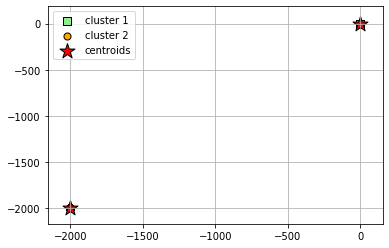

In [48]:
print(max(train_X[0]))
plt.scatter(
    train_X[y_km == 0, 0], train_X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    train_X[y_km == 1, 0], train_X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plt.scatter(
#     train_X[y_km == 2, 0], train_X[y_km == 2, 1],
#     s=50, c='lightblue',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plt.scatter(
#     train_images[y_km == 3, 0], train_images[y_km == 3, 1],
#     s=50, c='blue',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plt.scatter(
#     train_images[y_km == 4, 0], train_images[y_km == 4, 1],
#     s=50, c='green',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plt.scatter(
#     train_images[y_km == 5, 0], train_images[y_km == 5, 1],
#     s=50, c='red',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plt.scatter(
#     train_images[y_km == 6, 0], train_images[y_km == 6, 1],
#     s=50, c='lightred',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plt.scatter(
#     train_images[y_km == 7, 0], train_images[y_km == 7, 1],
#     s=50, c='pink',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()